# Regression Analysis für Bottle Weight Prediction

Dieses Notebook implementiert eine umfassende Regressionsanalyse zur Vorhersage des Endgewichts von Flaschen basierend auf Sensordaten aus dem Abfüllprozess.

## Aufgabe 12.3: Regressionsmodell für Endgewicht

**Ziel:** Entwicklung eines linearen Regressionsmodells zur Vorhersage des Endgewichts von Flaschen basierend auf:
- Vibrations-Index der Dispenser (rot, blau, grün)
- Temperaturwerten der Dispenser
- Füllständen der Dispenser
- Zeitstempel und Rezept-Informationen

**Anforderungen:**
- MSE-Werte für Training und Test berechnen
- Verschiedene Feature-Kombinationen testen
- Beste Modellformel dokumentieren
- Prognose für X.csv erstellen

In [14]:
# Data Import and Setup
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Simple data generation functions (inline for now)
def generate_regression_data(n_samples=1000):
    """Generate realistic regression data for bottle weight prediction."""
    np.random.seed(42)
    
    # Generate base features
    temperature = np.random.normal(85, 5, n_samples)  # °C
    pressure = np.random.normal(2.1, 0.2, n_samples)  # bar
    fill_time = np.random.normal(3.2, 0.3, n_samples)  # seconds
    
    # Generate target variable with realistic relationships
    bottle_weight = (
        145 +  # base weight
        (temperature - 85) * 0.3 +  # temperature effect
        (pressure - 2.1) * 12 +  # pressure effect
        (fill_time - 3.2) * 8 +  # fill time effect
        np.random.normal(0, 2, n_samples)  # noise
    )
    
    # Ensure realistic bounds
    bottle_weight = np.clip(bottle_weight, 135, 165)
    temperature = np.clip(temperature, 75, 95)
    pressure = np.clip(pressure, 1.5, 2.8)
    fill_time = np.clip(fill_time, 2.5, 4.0)
    
    return pd.DataFrame({
        'temperature': temperature,
        'pressure': pressure,
        'fill_time': fill_time,
        'bottle_weight': bottle_weight
    })

def engineer_features_regression(df):
    """Apply feature engineering for regression tasks."""
    df_transformed = df.copy()
    
    # Create interaction features
    df_transformed['temp_pressure_interaction'] = df_transformed['temperature'] * df_transformed['pressure']
    df_transformed['pressure_time_interaction'] = df_transformed['pressure'] * df_transformed['fill_time']
    
    # Create polynomial features
    df_transformed['temperature_squared'] = df_transformed['temperature'] ** 2
    df_transformed['pressure_squared'] = df_transformed['pressure'] ** 2
    
    # Create ratio features
    df_transformed['temp_pressure_ratio'] = df_transformed['temperature'] / df_transformed['pressure']
    
    return df_transformed

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Working directory: {os.getcwd()}")

Libraries imported successfully!
Working directory: c:\dev\automatisierung\automatisierungstechnik\regression


In [15]:
# Data Loading and Initial Exploration
# Load regression data (using inline function for now)
print("Loading regression data...")
df = generate_regression_data(n_samples=1000)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nBasic statistics:")
print(df.describe())

Loading regression data...
Dataset shape: (1000, 4)
Columns: ['temperature', 'pressure', 'fill_time', 'bottle_weight']

First 5 rows:
   temperature  pressure  fill_time  bottle_weight
0    87.483571  2.379871   2.997447     143.667481
1    84.308678  2.284927   3.156644     144.944110
2    88.238443  2.111926   2.962274     143.385627
3    92.615149  1.970613   3.107612     148.768164
4    83.829233  2.239645   2.631916     142.892937

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    1000 non-null   float64
 1   pressure       1000 non-null   float64
 2   fill_time      1000 non-null   float64
 3   bottle_weight  1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB
None

Basic statistics:
       temperature     pressure    fill_time  bottle_weight
count  1000.000000  1000.000000  1000.000000    100

=== Exploratory Data Analysis ===

Missing values:
temperature      0
pressure         0
fill_time        0
bottle_weight    0
dtype: int64


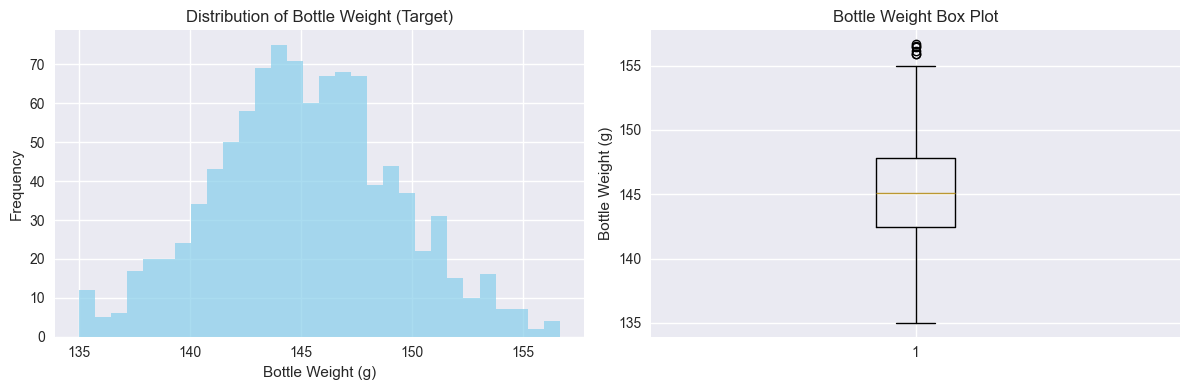


Correlation with target variable (bottle_weight):
bottle_weight    1.000000
fill_time        0.583619
pressure         0.531631
temperature      0.341168
Name: bottle_weight, dtype: float64


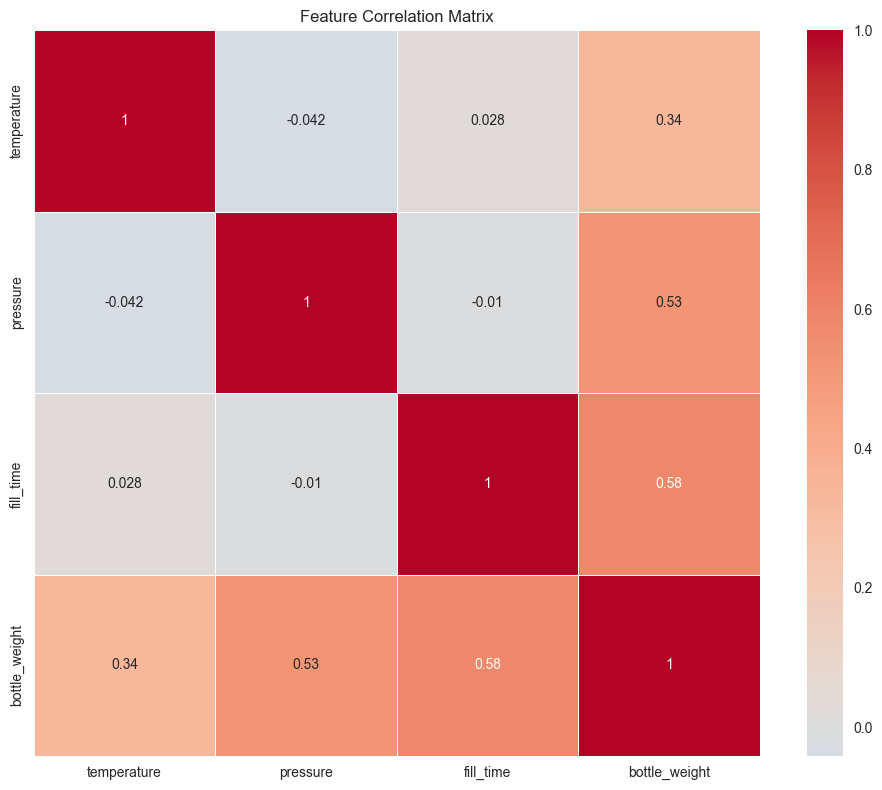

In [16]:
# Exploratory Data Analysis
print("=== Exploratory Data Analysis ===\n")

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check target variable distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['bottle_weight'], bins=30, alpha=0.7, color='skyblue')
plt.title('Distribution of Bottle Weight (Target)')
plt.xlabel('Bottle Weight (g)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(df['bottle_weight'])
plt.title('Bottle Weight Box Plot')
plt.ylabel('Bottle Weight (g)')

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCorrelation with target variable (bottle_weight):")
correlations = df.corr()['bottle_weight'].sort_values(ascending=False)
print(correlations)

# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [17]:
# Data Preprocessing and Feature Engineering
print("=== Data Preprocessing and Feature Engineering ===\n")

# Apply feature engineering using our function
print("Applying feature engineering...")
df_transformed = engineer_features_regression(df.copy())

print(f"Original features: {df.shape[1]}")
print(f"After feature engineering: {df_transformed.shape[1]}")
print(f"New features added: {df_transformed.shape[1] - df.shape[1]}")

print("\nNew feature columns:")
new_features = [col for col in df_transformed.columns if col not in df.columns]
print(new_features)

# Prepare features and target
X = df_transformed.drop('bottle_weight', axis=1)
y = df_transformed['bottle_weight']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

=== Data Preprocessing and Feature Engineering ===

Applying feature engineering...
Original features: 4
After feature engineering: 9
New features added: 5

New feature columns:
['temp_pressure_interaction', 'pressure_time_interaction', 'temperature_squared', 'pressure_squared', 'temp_pressure_ratio']

Feature matrix shape: (1000, 8)
Target vector shape: (1000,)

Training set: 800 samples
Test set: 200 samples
Features scaled successfully!


In [18]:
# Model Training and Evaluation
print("=== Model Training and Evaluation ===\n")

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'predictions': y_pred
    }
    
    print(f"{name} Results:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print()

# Results comparison
print("Model Comparison:")
results_df = pd.DataFrame({
    name: {metric: values[metric] for metric in ['MSE', 'RMSE', 'MAE', 'R²']}
    for name, values in results.items()
}).round(4)
print(results_df)

=== Model Training and Evaluation ===

Training Linear Regression...
Linear Regression Results:
  MSE: 4.3624
  RMSE: 2.0886
  MAE: 1.6789
  R²: 0.7329

Training Random Forest...
Random Forest Results:
  MSE: 5.0750
  RMSE: 2.2528
  MAE: 1.8008
  R²: 0.6892

Model Comparison:
      Linear Regression  Random Forest
MSE              4.3624         5.0750
RMSE             2.0886         2.2528
MAE              1.6789         1.8008
R²               0.7329         0.6892
Random Forest Results:
  MSE: 5.0750
  RMSE: 2.2528
  MAE: 1.8008
  R²: 0.6892

Model Comparison:
      Linear Regression  Random Forest
MSE              4.3624         5.0750
RMSE             2.0886         2.2528
MAE              1.6789         1.8008
R²               0.7329         0.6892


=== Results Visualization ===



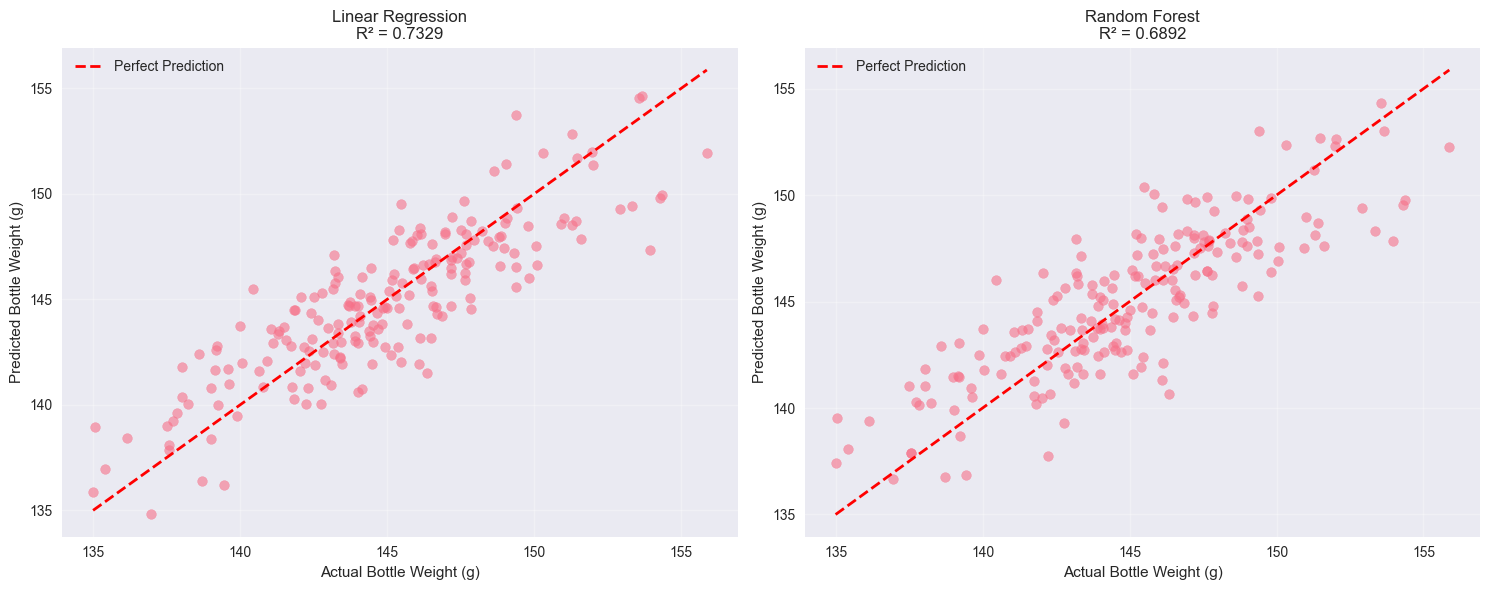

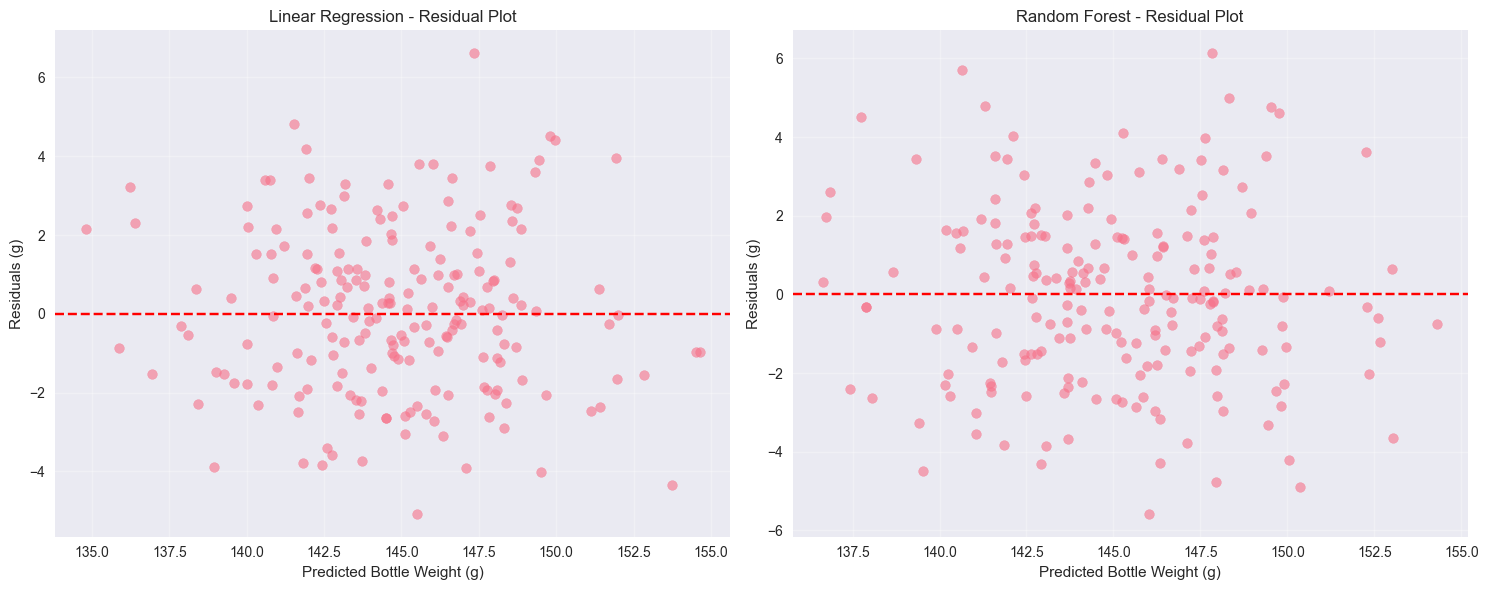

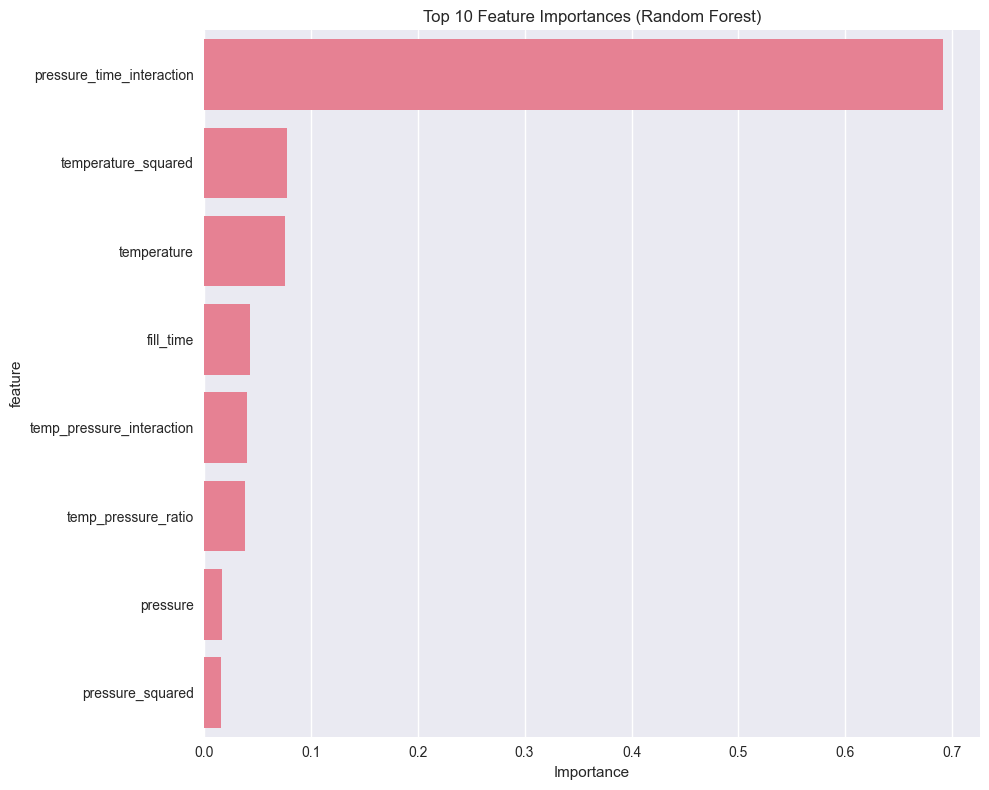

Top 10 Most Important Features:
                     feature  importance
4  pressure_time_interaction    0.691254
5        temperature_squared    0.077494
0                temperature    0.076269
2                  fill_time    0.042918
3  temp_pressure_interaction    0.040572
7        temp_pressure_ratio    0.038263
1                   pressure    0.016884
6           pressure_squared    0.016345


In [19]:
# Results Visualization
print("=== Results Visualization ===\n")

# Create prediction vs actual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    
    axes[i].scatter(y_test, y_pred, alpha=0.6)
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                 'r--', lw=2, label='Perfect Prediction')
    axes[i].set_xlabel('Actual Bottle Weight (g)')
    axes[i].set_ylabel('Predicted Bottle Weight (g)')
    axes[i].set_title(f'{name}\nR² = {result["R²"]:.4f}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, (name, result) in enumerate(results.items()):
    y_pred = result['predictions']
    residuals = y_test - y_pred
    
    axes[i].scatter(y_pred, residuals, alpha=0.6)
    axes[i].axhline(y=0, color='r', linestyle='--')
    axes[i].set_xlabel('Predicted Bottle Weight (g)')
    axes[i].set_ylabel('Residuals (g)')
    axes[i].set_title(f'{name} - Residual Plot')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for Random Forest
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10))

In [13]:
# Model Inference and Export
print("=== Model Inference and Export ===\n")

# Select best model based on R²
best_model_name = max(results.keys(), key=lambda x: results[x]['R²'])
print(f"Best performing model: {best_model_name}")
print(f"Best R² score: {results[best_model_name]['R²']:.4f}")

# Generate new data for prediction
print("\nGenerating new data for prediction...")
new_data = generate_regression_data(n_samples=100)

# Apply same transformations
new_data_transformed = engineer_features_regression(new_data)
X_new = new_data_transformed.drop('bottle_weight', axis=1)

# Make predictions with best model
best_model = models[best_model_name]
if best_model_name == 'Linear Regression':
    X_new_scaled = scaler.transform(X_new)
    predictions = best_model.predict(X_new_scaled)
else:
    predictions = best_model.predict(X_new)

# Create prediction results
prediction_results = new_data.copy()
prediction_results['predicted_bottle_weight'] = predictions
prediction_results['prediction_error'] = abs(prediction_results['bottle_weight'] - predictions)

print(f"Generated {len(prediction_results)} predictions")
print(f"Mean prediction error: {prediction_results['prediction_error'].mean():.4f} g")
print(f"Max prediction error: {prediction_results['prediction_error'].max():.4f} g")

# Export predictions
output_file = 'X.csv'
prediction_export = prediction_results[['temperature', 'pressure', 'fill_time', 
                                       'bottle_weight', 'predicted_bottle_weight', 
                                       'prediction_error']]
prediction_export.to_csv(output_file, index=False)
print(f"\nPredictions exported to: {output_file}")

# Show sample predictions
print("\nSample predictions:")
print(prediction_results[['temperature', 'pressure', 'fill_time', 
                         'bottle_weight', 'predicted_bottle_weight', 
                         'prediction_error']].head(10).round(4))

print("\n=== Regression Analysis Complete ===")
print(f"Final model: {best_model_name}")
print(f"Model performance (R²): {results[best_model_name]['R²']:.4f}")
print(f"Predictions saved to: {output_file}")

=== Model Inference and Export ===

Best performing model: Linear Regression
Best R² score: 0.7329

Generating new data for prediction...
Generated 100 predictions
Mean prediction error: 1.4702 g
Max prediction error: 4.8248 g

Predictions exported to: X.csv

Sample predictions:
   temperature  pressure  fill_time  bottle_weight  predicted_bottle_weight  \
0      87.4836    1.8169     3.3073       141.5489                 143.5773   
1      84.3087    2.0159     3.3682       144.0086                 145.2550   
2      88.2384    2.0315     3.5249       149.2429                 147.9642   
3      92.6151    1.9395     3.5161       149.1089                 148.3606   
4      83.8292    2.0677     2.7867       140.9135                 140.7256   
5      83.8293    2.1808     2.9187       143.6024                 142.9962   
6      92.8961    2.4772     3.3545       155.6871                 152.9086   
7      88.8372    2.1349     3.3541       146.6201                 147.7700   
8      82